# Intro

## Initial settings

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os,random, math, psutil, pickle 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import pandas as pd
import seaborn as sns
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sns.set()
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Import modelling libs
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

## Reducing Memory Size Function

In [ ]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Loading data

### Mounting google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Reading the pickle file

In [ ]:
# for jupyter lab
#train = pd.read_pickle('clean_data')

# for google colab
train = pd.read_pickle('/content/drive/My Drive/phd project/clean_data')

In [ ]:
# for jupyter lab
#holidays = pd.read_csv('UKholidays.csv')

# for google colab
holidays = pd.read_csv('/content/drive/My Drive/phd project/UKholidays.csv')

In [6]:
train = reduce_mem_usage(train)

holidays = reduce_mem_usage(holidays)

Mem. usage decreased to  7.06 Mb (25.0% reduction)
Mem. usage decreased to  0.01 Mb (28.8% reduction)


## Data description

In [7]:
train.info()

holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411298 entries, 0 to 411297
Data columns (total 3 columns):
meter_reading    359652 non-null float16
timestamp        411298 non-null datetime64[ns]
site_id          411298 non-null object
dtypes: datetime64[ns](1), float16(1), object(1)
memory usage: 7.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 3 columns):
date            385 non-null object
name            385 non-null object
bank_holiday    385 non-null int8
dtypes: int8(1), object(2)
memory usage: 6.5+ KB


In [8]:
holidays.head()

,date,name,bank_holiday
0,1/1/2009,New Year's Day,1
1,1/25/2009,Robert Burns Night (Burns Night),0
2,1/27/2009,Holocaust Memorial Day,0
3,2/14/2009,Valentines Day,0
4,2/24/2009,Shrove Tuesday (Pancake Day),0


In [9]:
print('Size of train_df data', train.shape)
print('Size of train_df data', holidays.shape)

Size of train_df data (411298, 3)
Size of train_df data (385, 3)


In [10]:
train.head()

,meter_reading,timestamp,site_id
0,0.286621,2015-02-15 00:00:00,A01
1,0.286621,2015-02-15 00:05:00,A01
2,0.285156,2015-02-15 00:10:00,A01
3,0.286621,2015-02-15 00:15:00,A01
4,0.238770,2015-02-15 00:20:00,A01


In [11]:
train.tail()

,meter_reading,timestamp,site_id
411293,0.234131,2015-03-28 23:40:00,F27
411294,0.159790,2015-03-28 23:45:00,F27
411295,0.333008,2015-03-28 23:50:00,F27
411296,1.342773,2015-03-28 23:55:00,F27
411297,1.344727,2015-03-29 00:00:00,F27


In [12]:
train.describe()

,meter_reading
count,359652.000000
mean,NaN
std,0.000000
min,0.000000
25%,0.102600
50%,0.196899
75%,0.371338
max,13.273438


In [13]:
train.dtypes.value_counts()

float16           1
datetime64[ns]    1
object            1
dtype: int64

In [14]:
#train['site_id'] = train['site_id'].astype('str')

train.site_id.unique()

array(['A01', 'A02', 'A03', 'A04', 'A07', 'A11', 'A13', 'A14', 'A18_app',
       'B02', 'B08', 'C02', 'C05', 'C06', 'C14', 'C16', 'C19', 'C24',
       'C26', 'C32', 'C33', 'C35', 'C40', 'C42', 'D01', 'D05', 'D08',
       'D10', 'D15', 'D16', 'D20a', 'D25b', 'F20', 'F27'], dtype=object)

### Group data on a daily basis

In [15]:
daily_train = train.copy()
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'site_id']).sum()
daily_train

meter_reading
date       site_id               
2015-02-15 A01          74.312500
           A02          94.250000
           A03          96.187500
           A04          42.468750
           A07          45.750000
...                           ...
2015-03-29 D16           0.178223
           D20a          0.227661
           D25b          0.188599
           F20           0.000000
           F27           1.344727

[1462 rows x 1 columns]

### Aggregate the data for buildings

In [16]:
daily_train_agg = daily_train.groupby(['date']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

,date,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2015-02-15,3662.0,107.6875,"(2015-02-15, B08)",442.75
1,2015-02-16,3686.0,108.3750,"(2015-02-16, C26)",576.00
2,2015-02-17,4112.0,120.9375,"(2015-02-17, C26)",536.50
3,2015-02-18,3648.0,107.3125,"(2015-02-18, C26)",422.00
4,2015-02-19,3544.0,104.2500,"(2015-02-19, C26)",444.75


### Adding datetime features

In [ ]:
train_df = train.copy()
train_df['month'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['week_of_year'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['day_of_year'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
train_df['hour_of_day'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_of_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_of_month'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_of_month'] = train_df['timestamp'].dt.day/7
train_df['week_of_month'] = train_df['week_of_month'].apply(lambda x: math.ceil(x)).astype(np.int8)

In [18]:
train_df.head()

,meter_reading,timestamp,site_id,month,week_of_year,day_of_year,hour_of_day,day_of_week,day_of_month,week_of_month
0,0.286621,2015-02-15 00:00:00,A01,2,7,46,0,6,15,3
1,0.286621,2015-02-15 00:05:00,A01,2,7,46,0,6,15,3
2,0.285156,2015-02-15 00:10:00,A01,2,7,46,0,6,15,3
3,0.286621,2015-02-15 00:15:00,A01,2,7,46,0,6,15,3
4,0.238770,2015-02-15 00:20:00,A01,2,7,46,0,6,15,3


In [19]:
convert_dict = {'site_id' : str,
                'month': int,
                'week_of_year': int,
                'day_of_year': int,
                'hour_of_day': int,
                'day_of_week': int,
                'day_of_month': int,
                'week_of_month': int,
                'meter_reading': float
               }

train_df = train_df.astype(convert_dict)

train_df.dtypes.value_counts()

int64             7
float64           1
datetime64[ns]    1
object            1
dtype: int64

### Saving the file

In [20]:
train_df.to_pickle('train_df.pkl')

#del train
del train_df

gc.collect()

58

In [21]:
# Loading the pickle file

train_df = pd.read_pickle('train_df.pkl')
train_df.head()

,meter_reading,timestamp,site_id,month,week_of_year,day_of_year,hour_of_day,day_of_week,day_of_month,week_of_month
0,0.286621,2015-02-15 00:00:00,A01,2,7,46,0,6,15,3
1,0.286621,2015-02-15 00:05:00,A01,2,7,46,0,6,15,3
2,0.285156,2015-02-15 00:10:00,A01,2,7,46,0,6,15,3
3,0.286621,2015-02-15 00:15:00,A01,2,7,46,0,6,15,3
4,0.238770,2015-02-15 00:20:00,A01,2,7,46,0,6,15,3


# EDA

## Ploting

### Daily and hourly demand for each building

IndexError: ignored

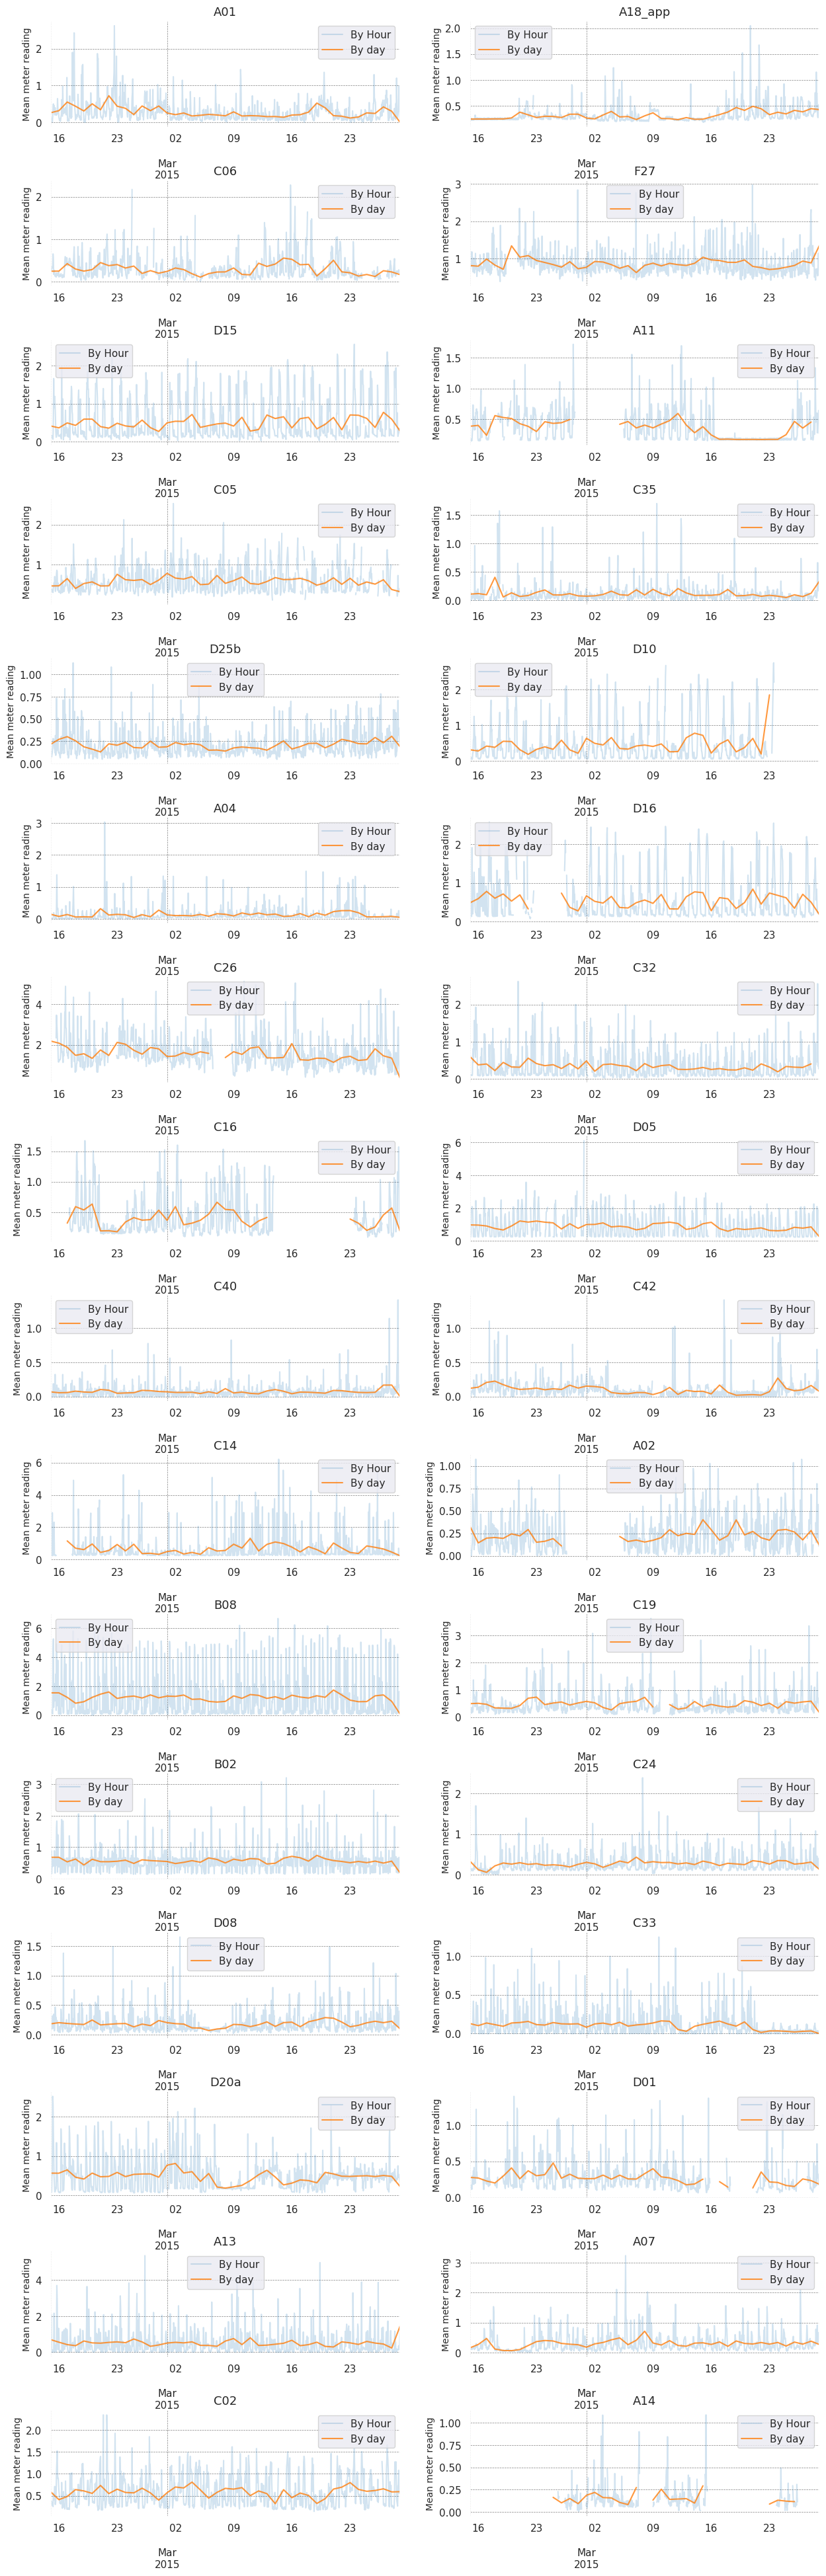

In [20]:
fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(15, 50), dpi=100)

for i, id in enumerate(train['site_id'].value_counts().index.to_list()):
    train[train['site_id'] == id][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%16][i//16], alpha=0.2, label='By Hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=10);
    train[train['site_id'] == id][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%16][i//16], alpha=0.8, label='By day', color='tab:orange').set_xlabel('');
    axes[i%16][i//16].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
    axes[i%16][i//16].patch.set_facecolor('white')
    axes[i%16][i//16].legend();
    axes[i%16][i//16].set_title(id, fontsize=13);
    plt.subplots_adjust(hspace=0.5)

### Missing data and zeros visualized

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1, 'Missing data and zeros visualized')

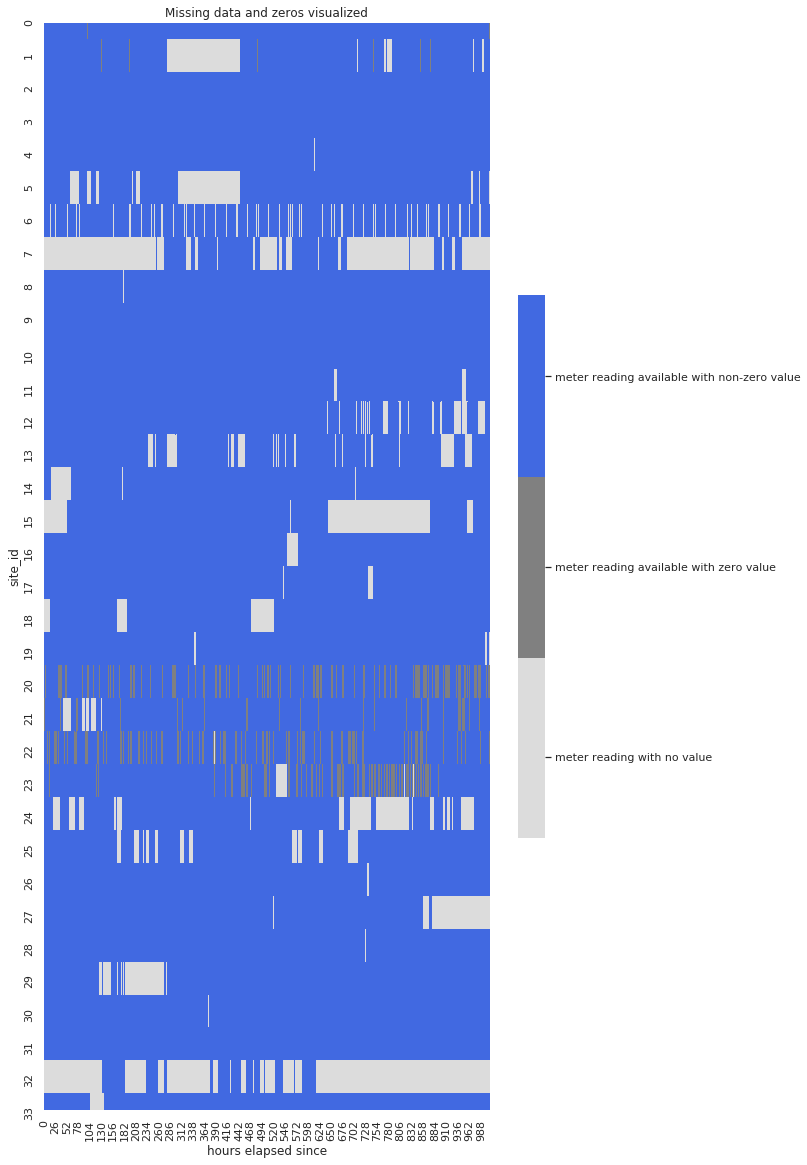

In [21]:
# Load data to another df
train_sns = train.set_index(['timestamp'])

# change the site_id to numbers first
train_sns['site_id'] = train_sns.site_id.replace(['A01', 'A02', 'A03', 'A04', 'A07', 'A11', 'A13', 'A14', 'A18_app',
       'B02', 'B08', 'C02', 'C05', 'C06', 'C14', 'C16', 'C19', 'C24',
       'C26', 'C32', 'C33', 'C35', 'C40', 'C42', 'D01', 'D05', 'D08',
       'D10', 'D15', 'D16', 'D20a', 'D25b', 'F20', 'F27'], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33])

f,ax=plt.subplots(1,1,figsize=(10,20))
df = train_sns.copy().reset_index()
df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
df['timestamp'] = df.timestamp.astype(int)
df.timestamp -= df.timestamp.min()

# create a new column for sites with no energy reading
df['nodata'] = 0
df.nodata[(df['meter_reading'].isnull())] = 1

# sum the meter reading for each hour
df = df.groupby(['timestamp', 'site_id']).sum()
df = df.reset_index()

missmap = np.empty((34, df.timestamp.max()+1))
missmap.fill(np.nan)
for l in df.values:
    if l[3]>=1 and l[2]==0:
        missmap[int(l[1]), int(l[0])] = 0
    elif l[2]==0:
        missmap[int(l[1]), int(l[0])] = 0.5
    else:
        missmap[int(l[1]), int(l[0])] = 1

# Define colors
from matplotlib.colors import LinearSegmentedColormap
colors = ('gainsboro', 'gray', 'royalblue')
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

sns.heatmap(missmap, cmap=cmap, ax=ax, cbar=True, cbar_kws={"shrink": .5})

# Set the colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.15, 0.5, 0.85])
colorbar.set_ticklabels(['meter reading with no value', 'meter reading available with zero value', 'meter reading available with non-zero value'])

# Set axis labels
ax.set_ylabel('site_id')    
ax.set_xlabel('hours elapsed since')
ax.set_title('Missing data and zeros visualized')

### Average meter_reading by hour

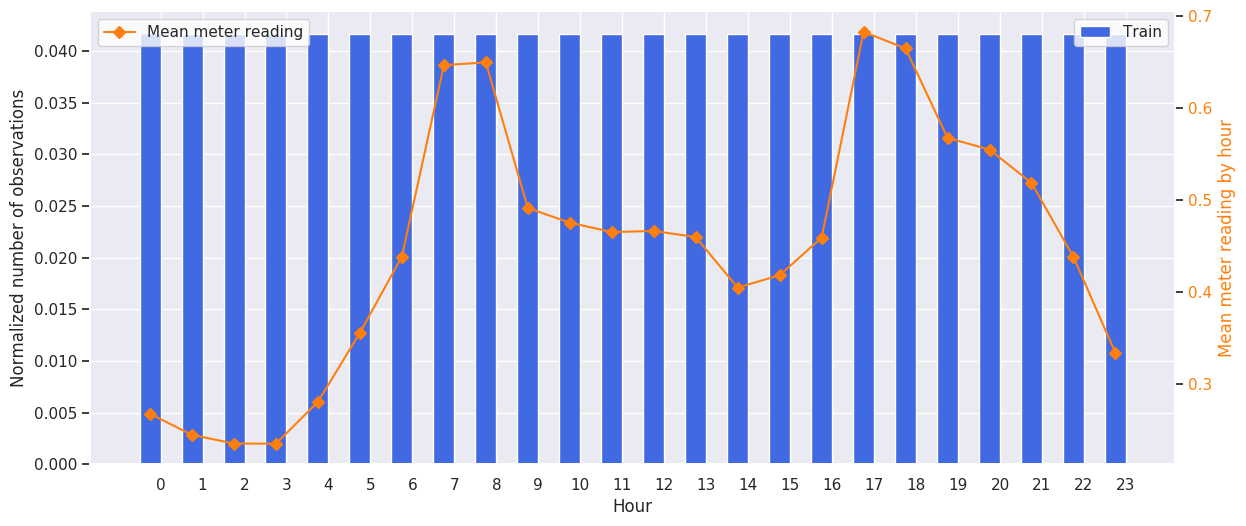

In [56]:
train_data = train_df['hour_of_day'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.5

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('Hour');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train_df['hour_of_day'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train_df[['hour_of_day', 'meter_reading']].groupby('hour_of_day')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by hour', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

### Average meter_reading by day

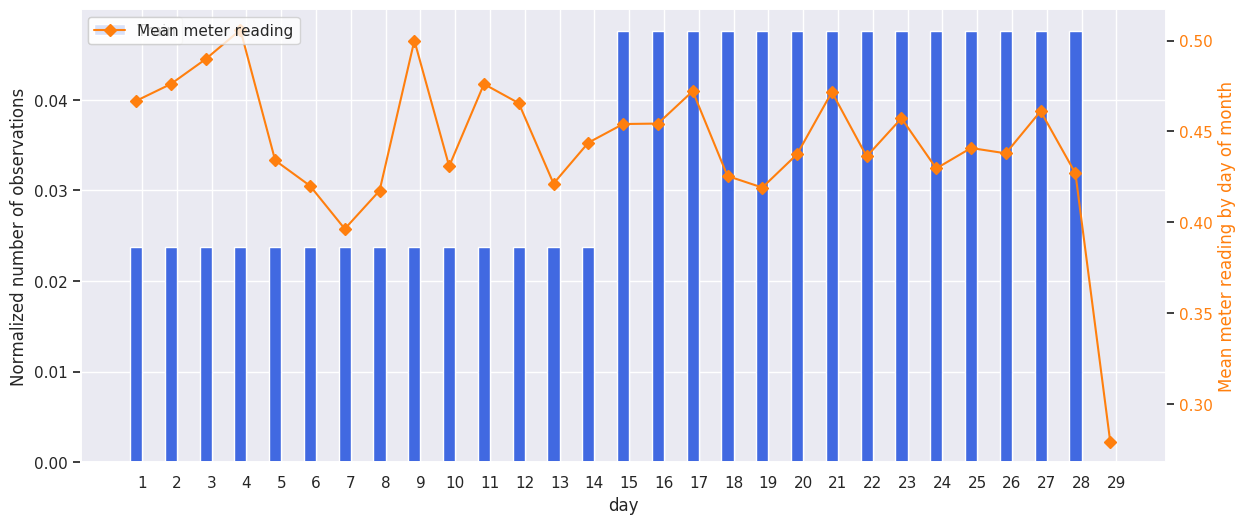

In [57]:
train_data = train_df['day_of_month'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('day');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train_df['day_of_month'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train_df[['day_of_month', 'meter_reading']].groupby('day_of_month')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of month', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

### Average meter_reading by weekday

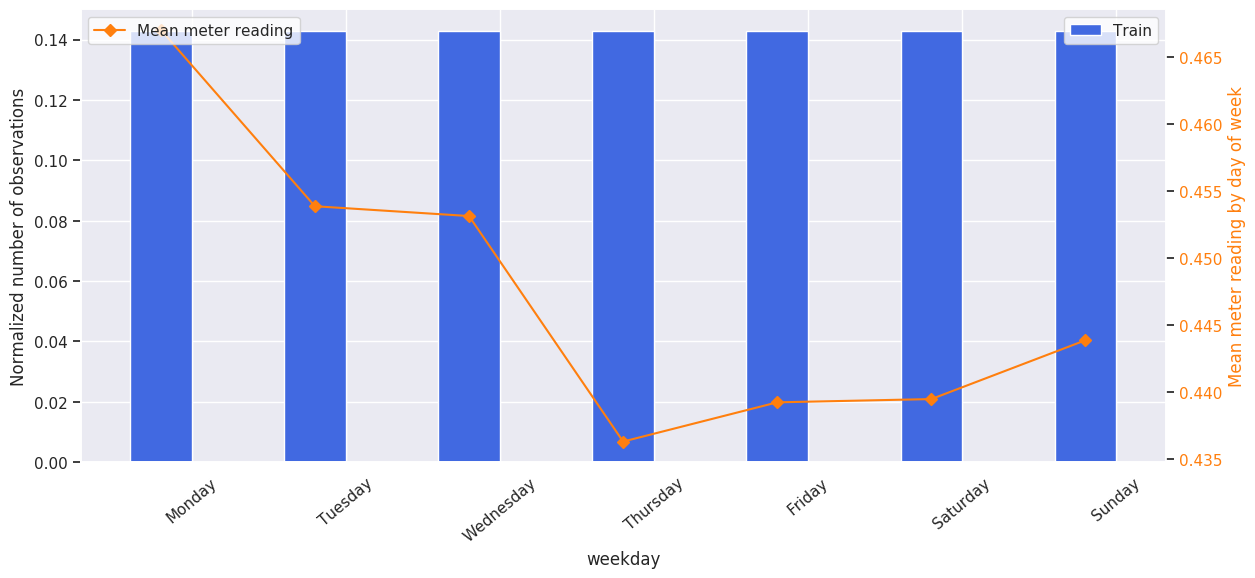

In [76]:
train_data = train_df['day_of_week'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.4

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('weekday');
axes.set_xticks(ind + width / 2)
axes2 = axes.twinx()
mr = axes2.plot(ind, train_df[['day_of_week', 'meter_reading']].groupby('day_of_week')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of week', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

axes.set_xticklabels(train_df['day_of_week'].value_counts().sort_index().index.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}), rotation=40);

### Average meter_reading by site_id

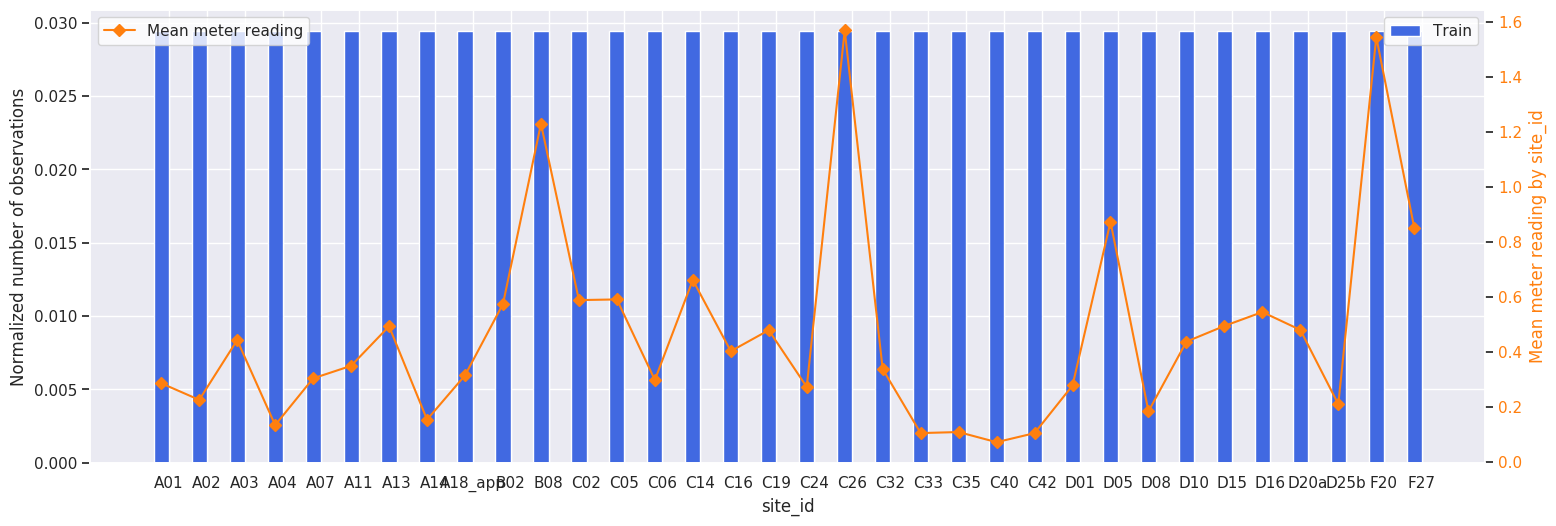

In [75]:
train_data = train_df['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.4

fig, axes = plt.subplots(1,1,figsize=(18, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train_df['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train_df[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

### Box plot of meter_readig by site_id

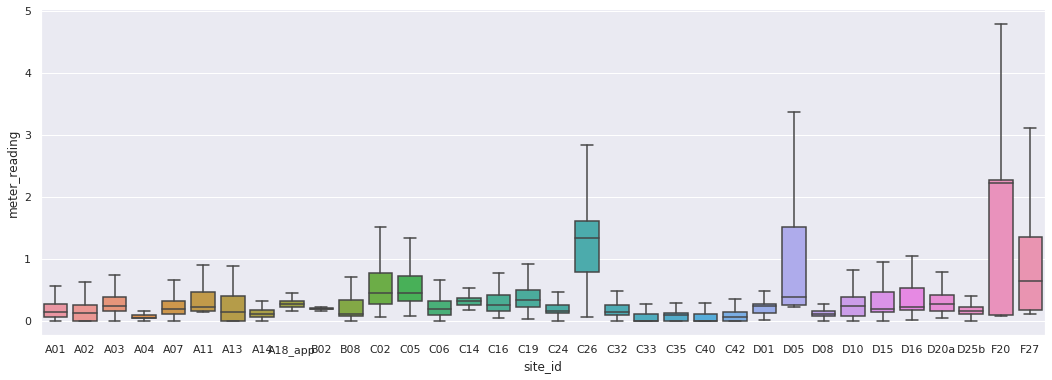

In [77]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
sns.boxplot(x='site_id', y='meter_reading', data=train_df, showfliers=False);

### Number of observations by day

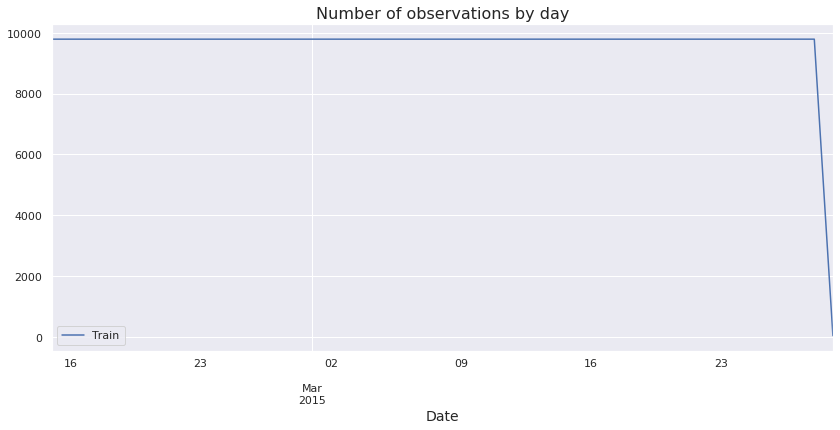

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
train_df['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train']);

### Amount of data and NaNs

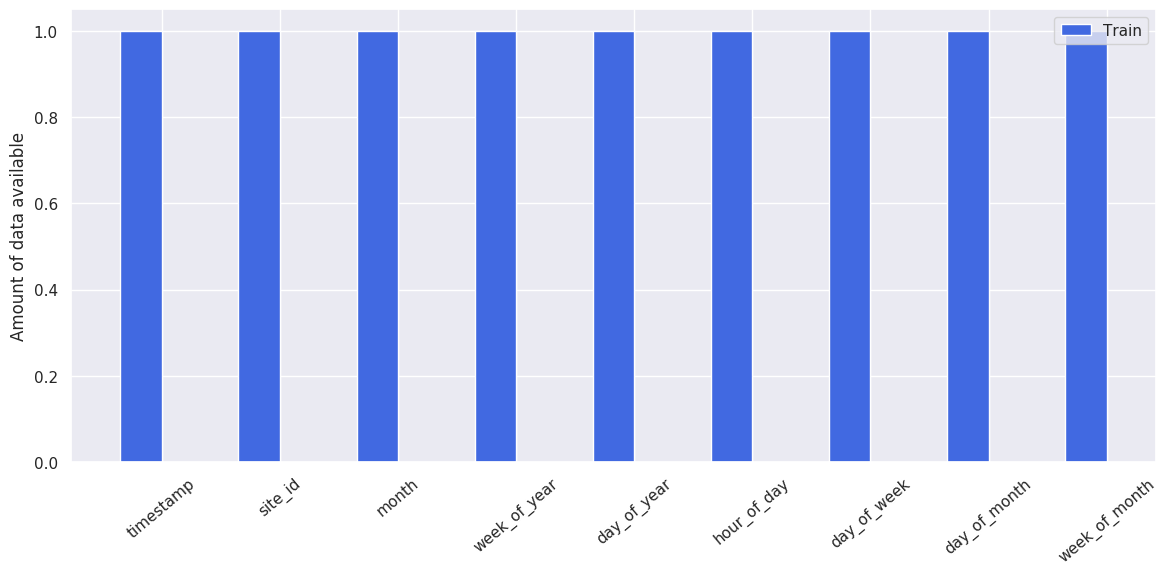

In [86]:
train_data = (train_df.count() / len(train_df)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train_df.count() / len(train_df)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr], ['Train']);

## Simple Single Series Analysis

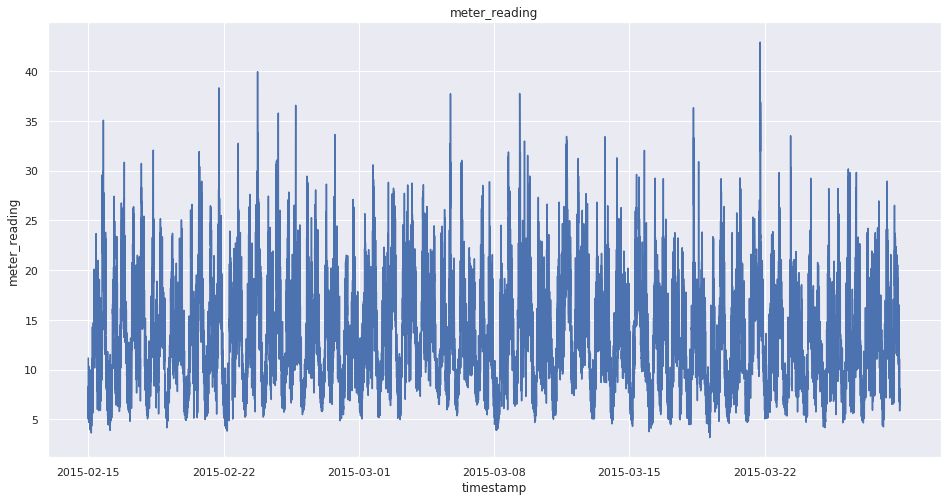

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts=train_df.groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts);

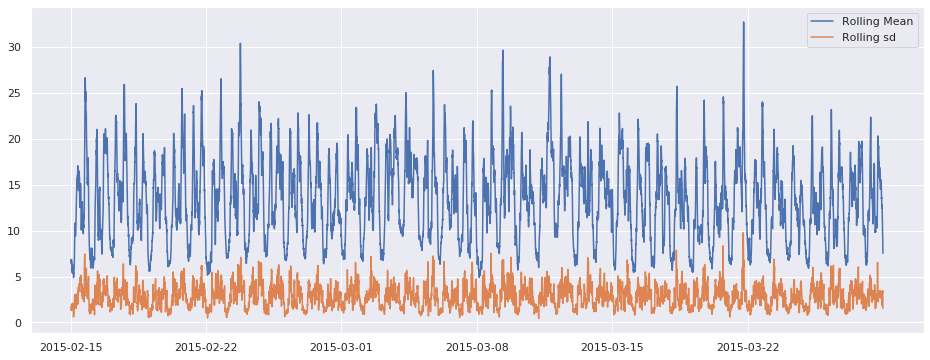

In [88]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

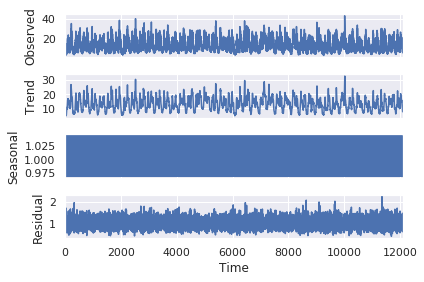

In [89]:
import statsmodels.api as sm
# multiplicative

res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

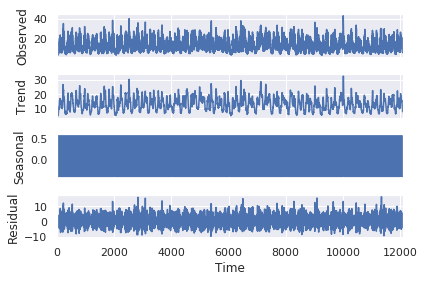

In [90]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
fig = res.plot()

## Examine the Distribution of the Target Column (meter_reading)

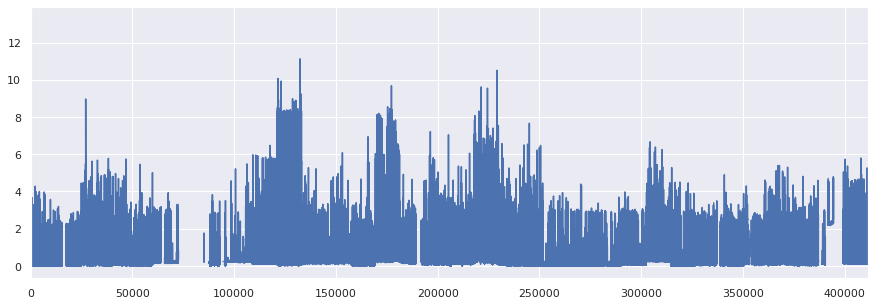

In [91]:
plt.figure(figsize = (15,5))
train_df['meter_reading'].plot()

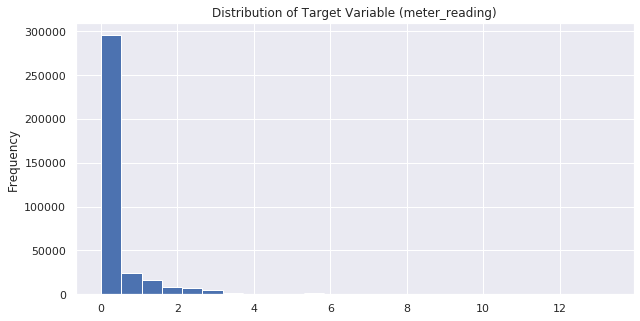

In [106]:
train_df['meter_reading'].plot(kind='hist',
                            bins=25,
                            figsize=(10, 5),
                           title='Distribution of Target Variable (meter_reading)')
plt.show()

count    359652.000000
mean               NaN
std           0.000000
min           0.000000
25%           0.102600
50%           0.196899
75%           0.371338
max          13.273438
Name: meter_reading, dtype: float64

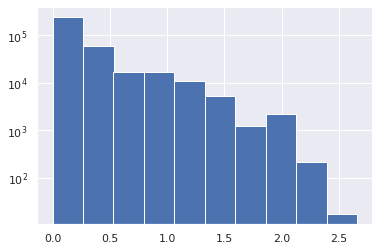

In [93]:
#Target's log-log histogram:

ax = np.log1p(train_df['meter_reading']).hist()
ax.set_yscale('log')
train_df.meter_reading.describe()

In [94]:
# Number of each type of column
train_df.dtypes.value_counts()

int8              6
datetime64[ns]    1
object            1
float16           1
int16             1
dtype: int64

In [95]:
# Number of unique classes in each object column
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

site_id    34
dtype: int64

## Handling missing values

In [96]:
import missingno as msno

total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(10)

,Total,Percent
meter_reading,51646,12.556832
week_of_month,0,0.000000
day_of_month,0,0.000000
day_of_week,0,0.000000
hour_of_day,0,0.000000
day_of_year,0,0.000000
week_of_year,0,0.000000
month,0,0.000000
site_id,0,0.000000
timestamp,0,0.000000


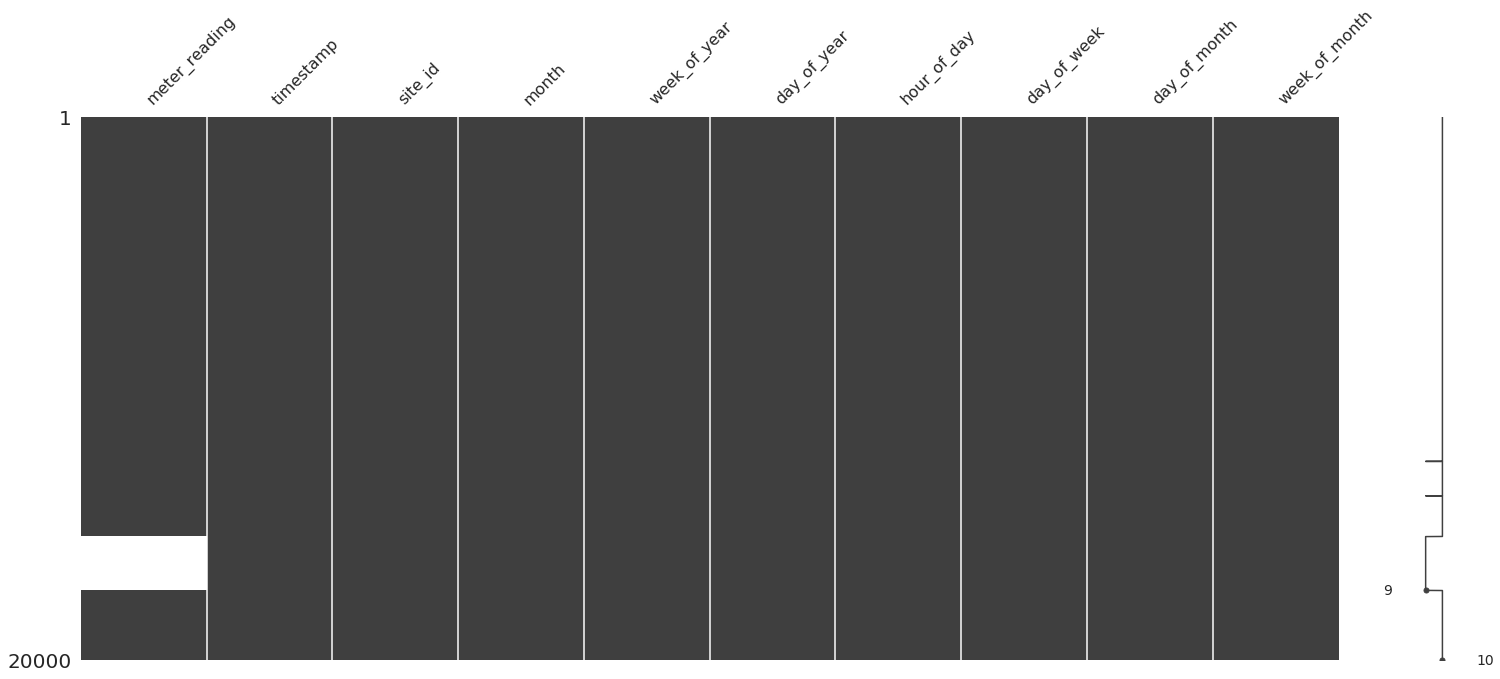

In [108]:
msno.matrix(train_df.head(20000))

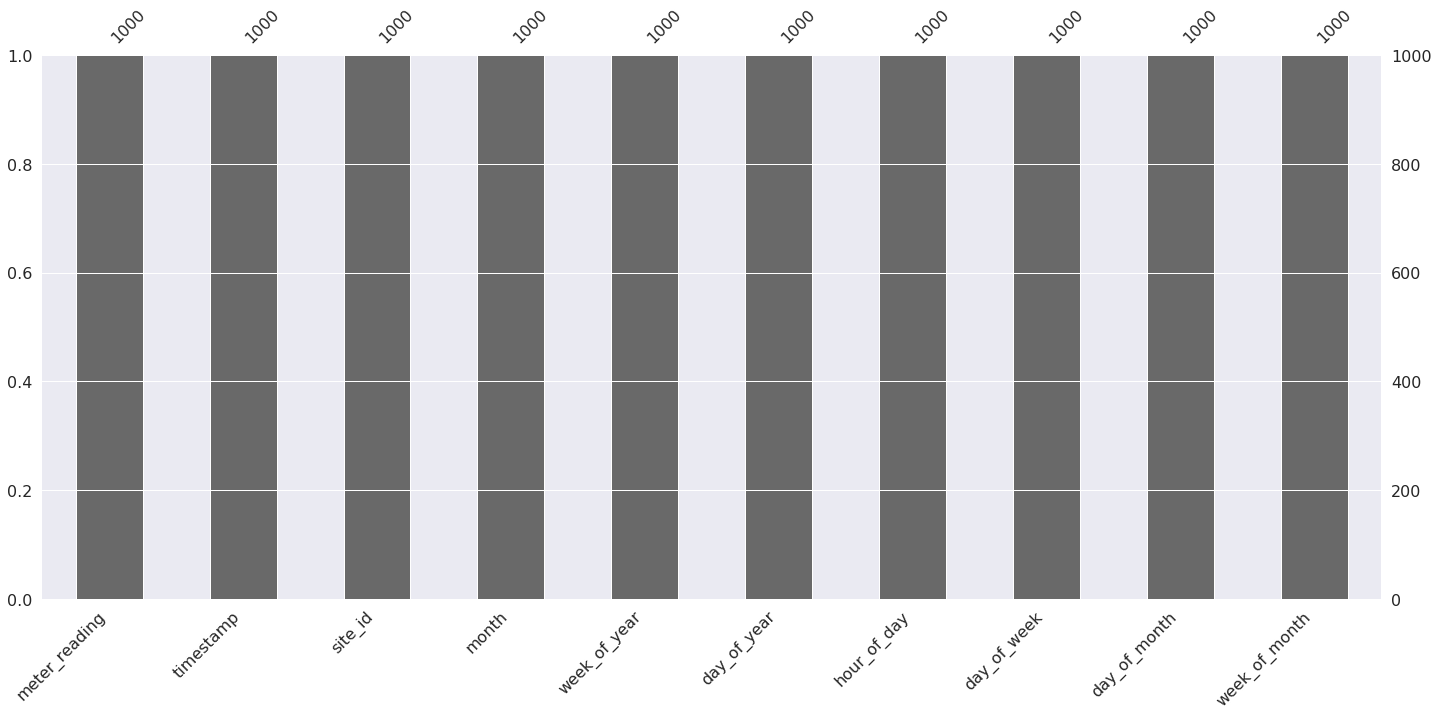

In [110]:
>>> msno.bar(train_df.head(1000))

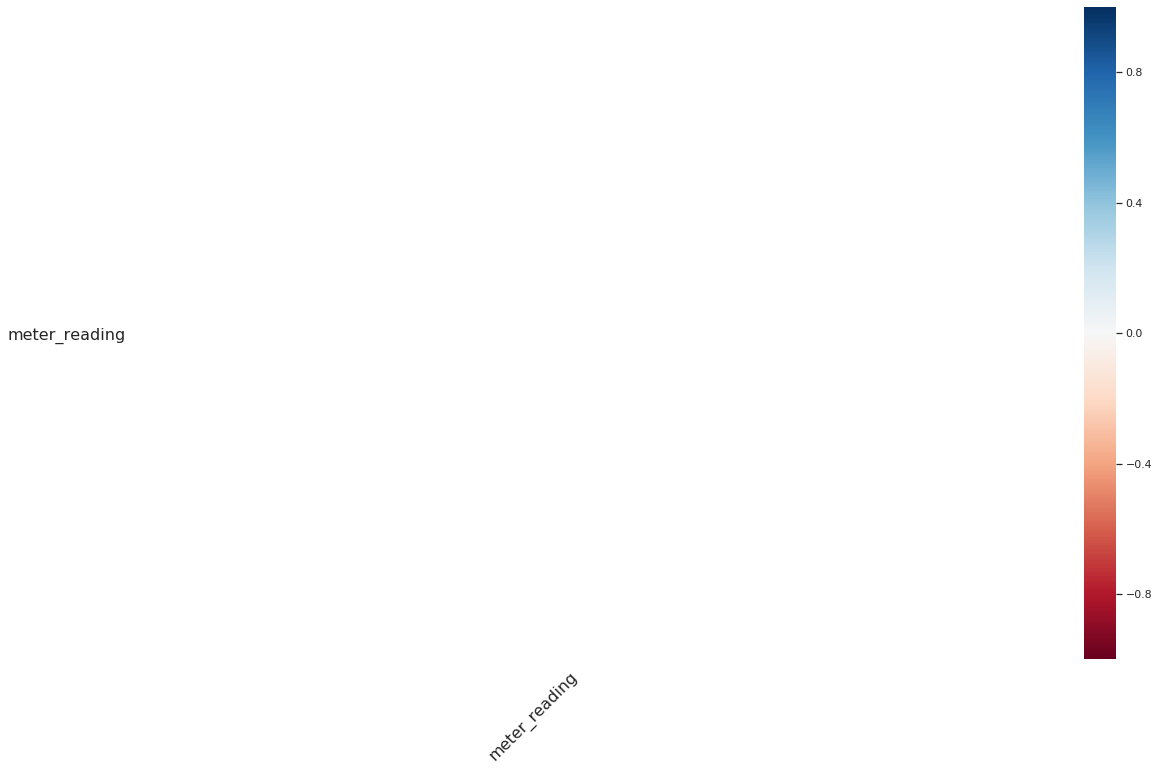

In [98]:
a = msno.heatmap(train_df, sort='ascending')

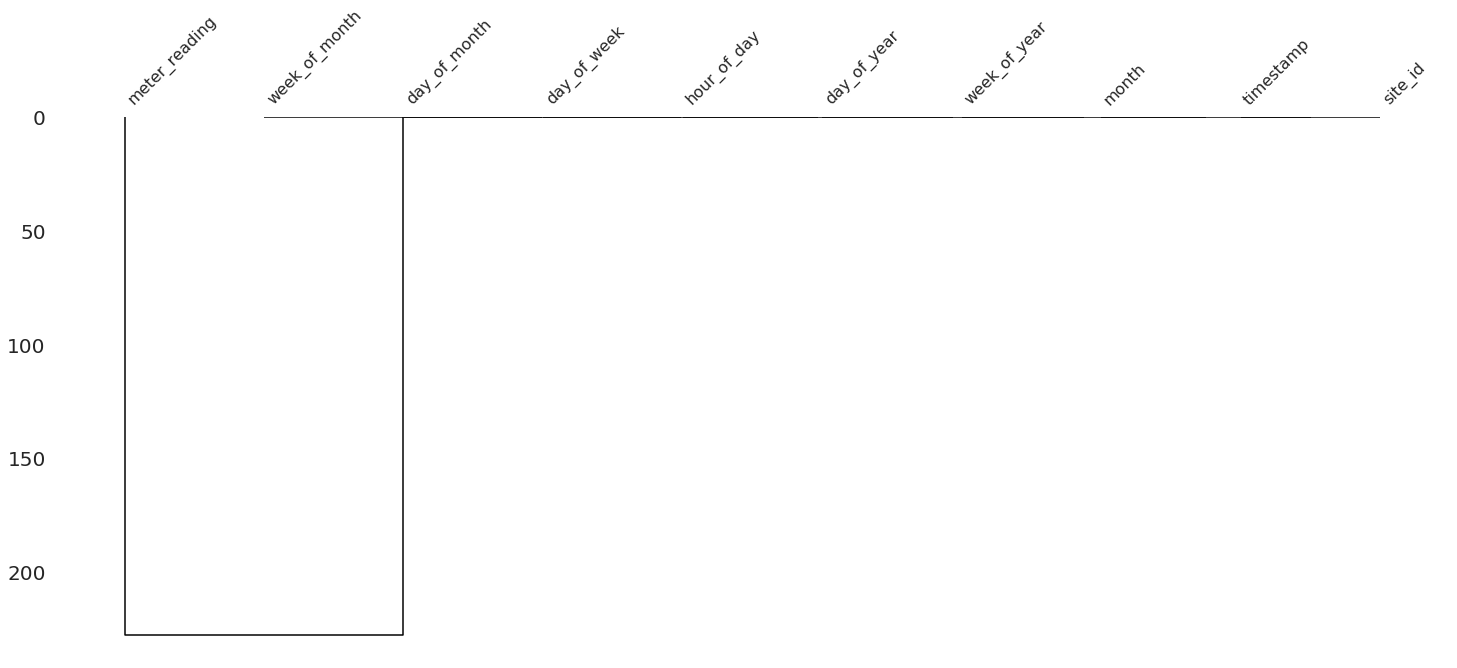

In [111]:
msno.dendrogram(train_df)

## Outlier analysis

posx and posy should be finite values
posx and posy should be finite values


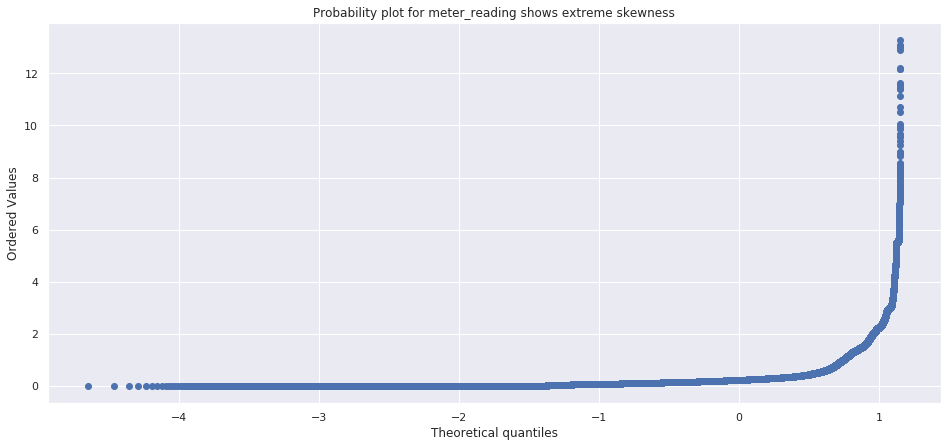

In [113]:
from scipy import stats
from scipy.stats import skew

plt.figure(figsize=(16,7))
_ = stats.probplot(train_df['meter_reading'], fit=True, rvalue=True, plot=plt)
plt.title("Probability plot for meter_reading shows extreme skewness")
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning:

invalid value encountered in less



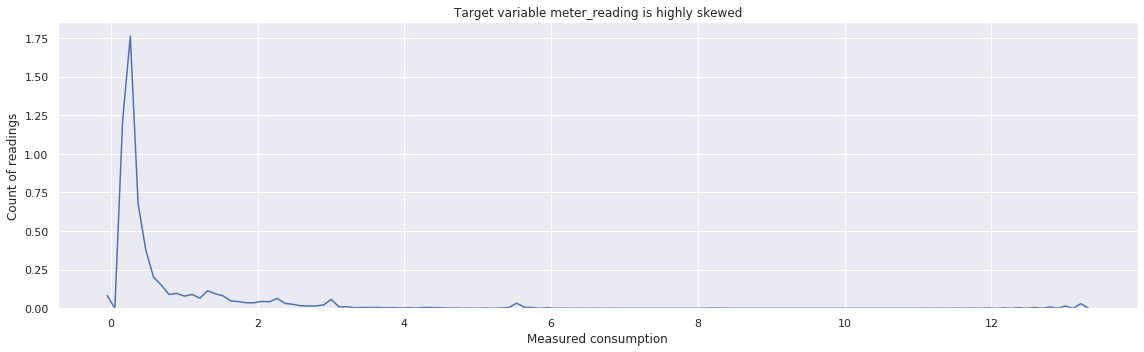

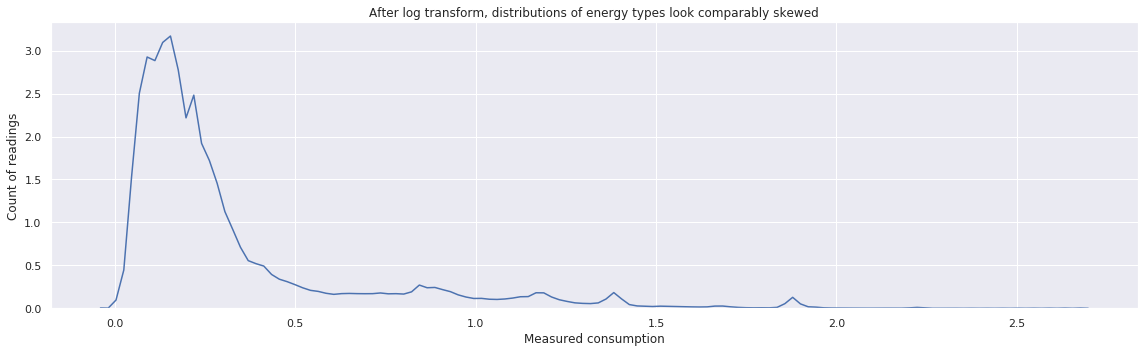

In [100]:
plt.figure(figsize=(16,5))
sns.distplot(train_df.meter_reading, hist=False)
plt.title(f"Target variable meter_reading is highly skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
sns.distplot(np.log1p(train_df.meter_reading), hist=False)
plt.title(f"After log transform, distributions of energy types look comparably skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.tight_layout()
plt.show()

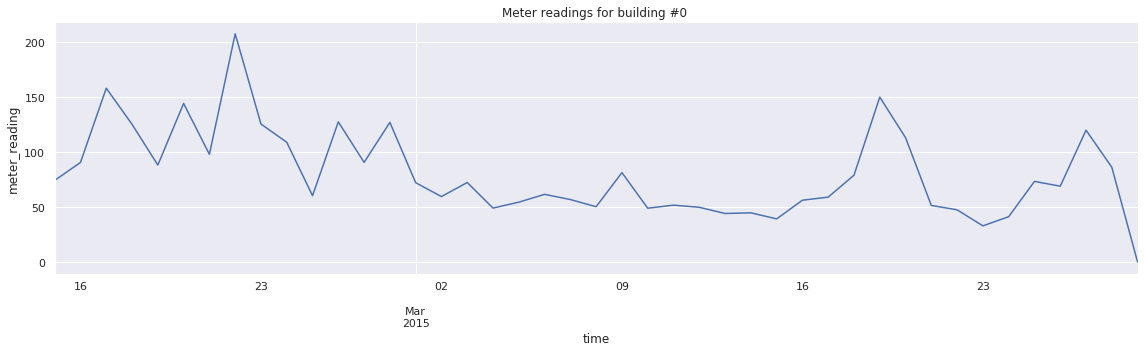

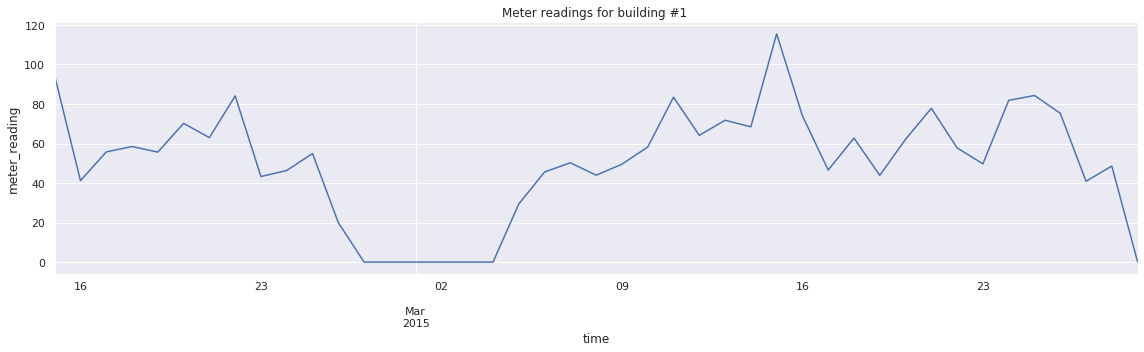

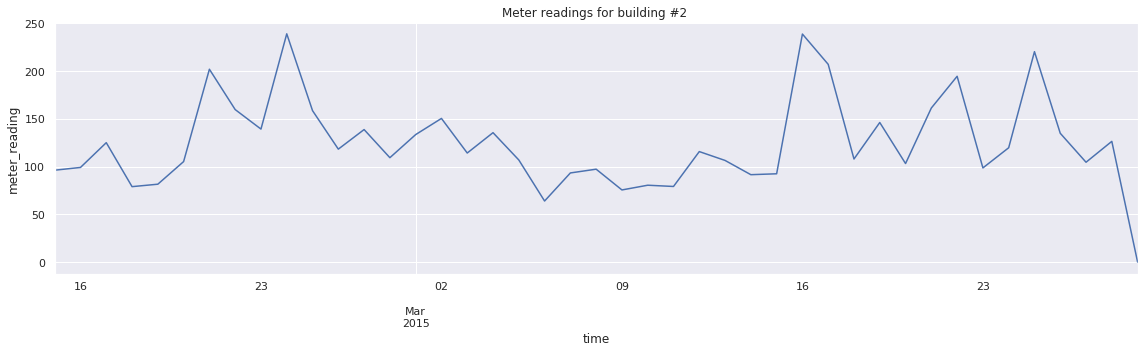

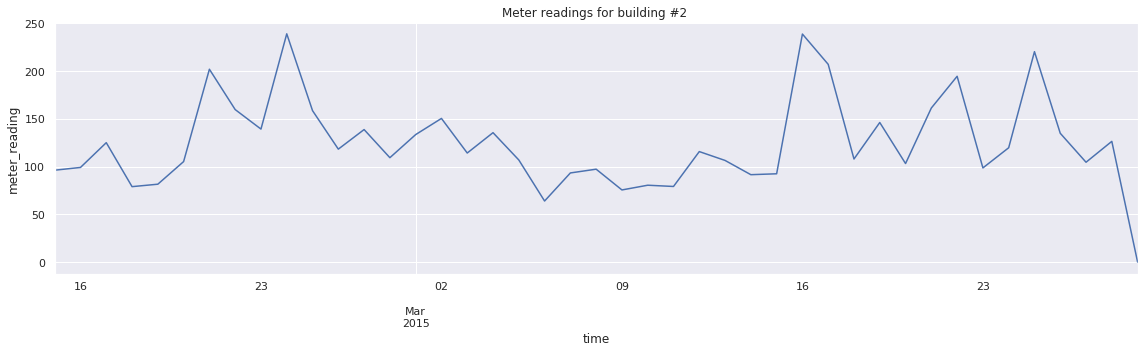

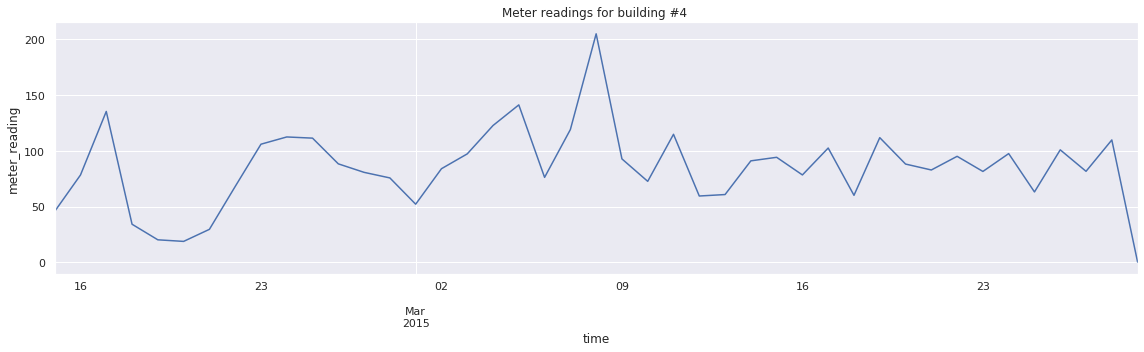

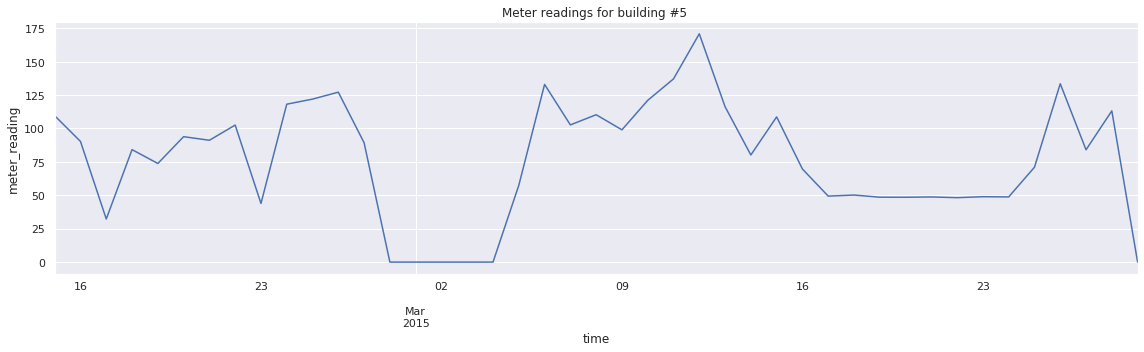

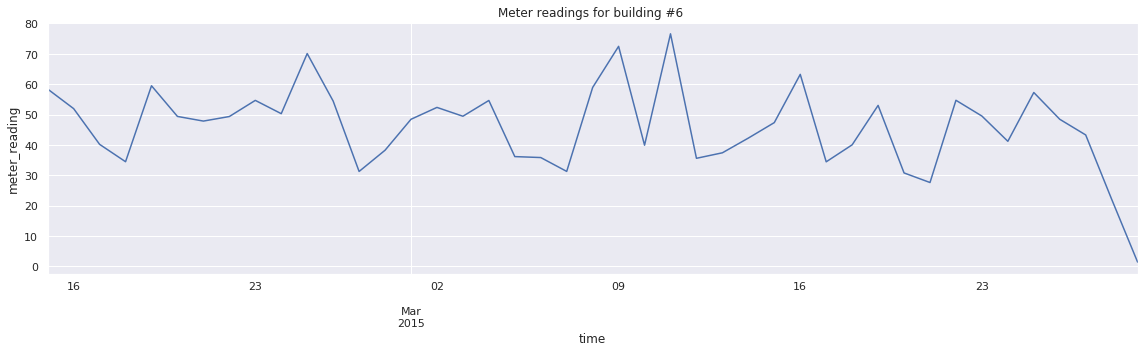

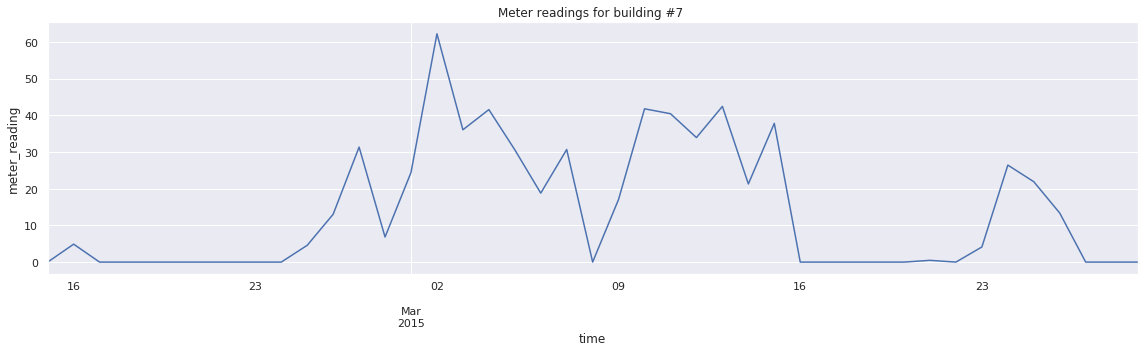

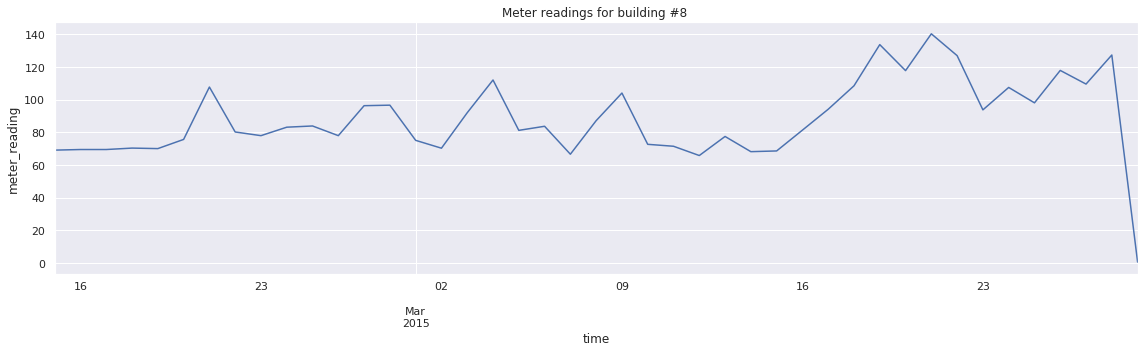

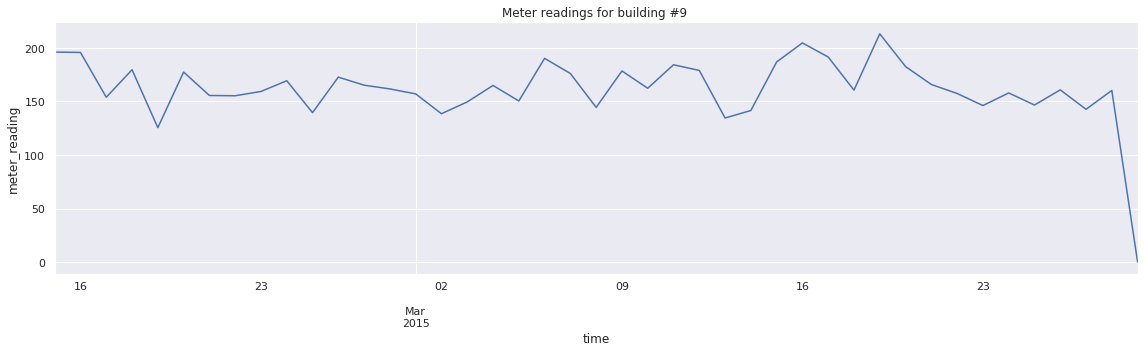

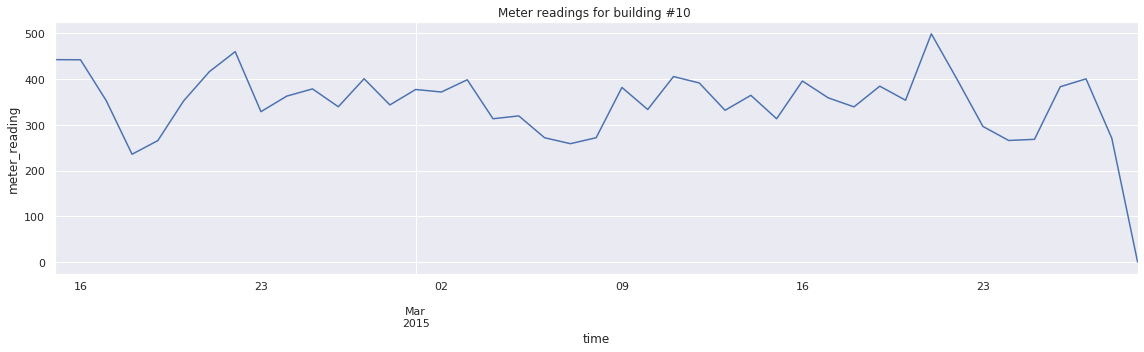

In [101]:
train_df2 = train_df.copy()

# change the site_id to numbers first
train_df2['site_id'] = train_df2.site_id.replace(['A01', 'A02', 'A03', 'A04', 'A07', 'A11', 'A13', 'A14', 'A18_app',
       'B02', 'B08', 'C02', 'C05', 'C06', 'C14', 'C16', 'C19', 'C24',
       'C26', 'C32', 'C33', 'C35', 'C40', 'C42', 'D01', 'D05', 'D08',
       'D10', 'D15', 'D16', 'D20a', 'D25b', 'F20', 'F27'], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33])

for bldg_id in [0, 1, 2, 2, 4,5, 6,7,8,9,10]:
    plt.figure(figsize=(16,5))
    tmp_df = train_df2[train_df2.site_id == bldg_id].copy()
    tmp_df.set_index("timestamp", inplace=True)
    tmp_df.resample("D").meter_reading.sum().plot()
    plt.title(f"Meter readings for building #{bldg_id} ")
    plt.xlabel("time")
    plt.ylabel("meter_reading")
    plt.tight_layout()
    plt.show()

### Outlier Distribution

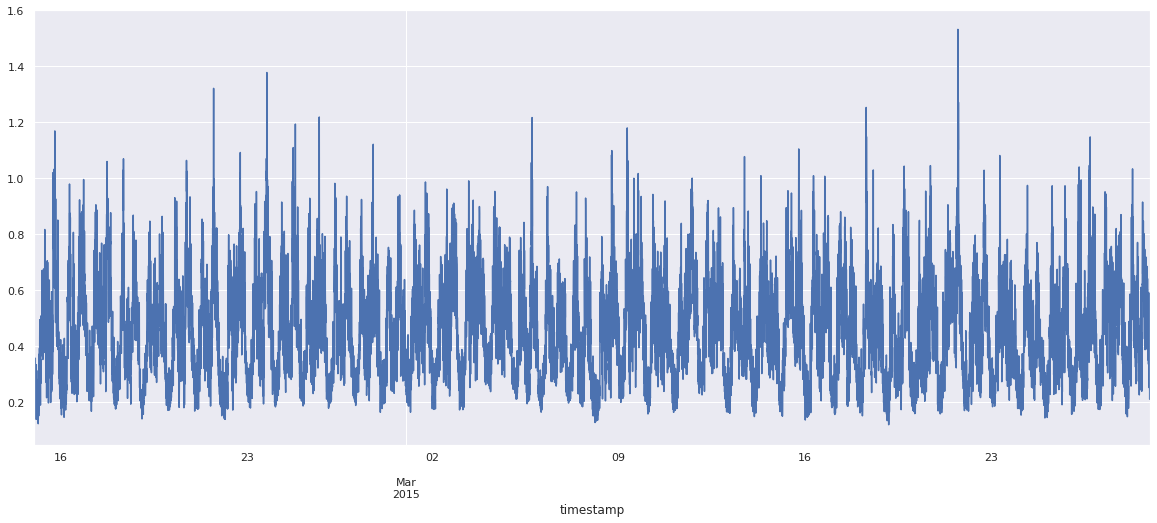

In [104]:
##Outlier Distribution

y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))

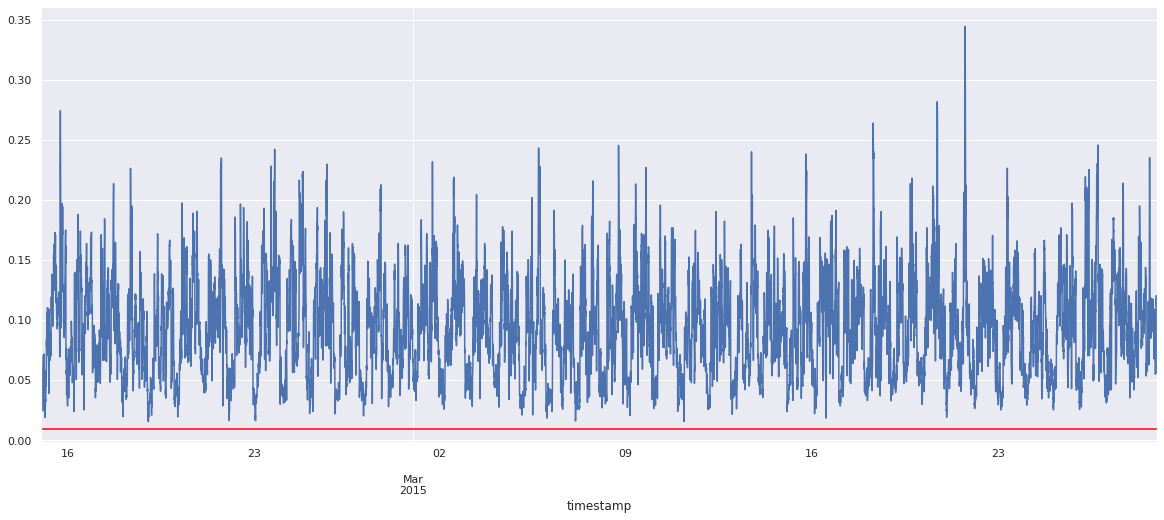

In [105]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
plt.axhline(y=0.009, color='red')
plt.axvspan(0, 23, color='green', alpha=0.1)

# Modelling (baseline)

### Loading data and spliting it

In [25]:
x = train_df.copy()

# change the site_id to numbers first
x['site_id'] = x.site_id.replace(['A01', 'A02', 'A03', 'A04', 'A07', 'A11', 'A13', 'A14', 'A18_app',
       'B02', 'B08', 'C02', 'C05', 'C06', 'C14', 'C16', 'C19', 'C24',
       'C26', 'C32', 'C33', 'C35', 'C40', 'C42', 'D01', 'D05', 'D08',
       'D10', 'D15', 'D16', 'D20a', 'D25b', 'F20', 'F27'], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33])

X = x.values

train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

traindf = pd.DataFrame(train, columns=['meter_reading', 'time', 'site_id', 'month', 'week_of_year', 'day_of_year', 'hour_of_day', 'day_of_week', 'day_of_month', 'week_of_month'])
testdf = pd.DataFrame(test, columns=['meter_reading', 'time', 'site_id', 'month', 'week_of_year', 'day_of_year', 'hour_of_day', 'day_of_week', 'day_of_month', 'week_of_month'])

Observations: 411298
Training Observations: 271456
Testing Observations: 139842


In [26]:
# changing the data types

convert_dict = {'site_id' : int,
                'month': int,
                'week_of_year': int,
                'day_of_year': int,
                'hour_of_day': int,
                'day_of_week': int,
                'day_of_month': int,
                'week_of_month': int,
                'meter_reading': float
               }

traindf = traindf.astype(convert_dict)
testdf = testdf.astype(convert_dict)

traindf = traindf.drop('time', axis = 1)
testdf = testdf.drop('time', axis = 1)
testdf = testdf.drop('meter_reading', axis = 1)

traindf.dtypes.value_counts()

int64      8
float64    1
dtype: int64

In [ ]:
# encoding the categorical columns
le = LabelEncoder()
traindf['site_id'] = le.fit_transform(traindf['site_id'])
testdf['site_id'] = le.fit_transform(testdf['site_id'])

#traindf['month'] = le.fit_transform(traindf['month'])
#traindf['week_of_year'] = le.fit_transform(traindf['week_of_year'])
#traindf['day_of_year'] = le.fit_transform(traindf['day_of_year'])
#traindf['hour_of_day'] = le.fit_transform(traindf['hour_of_day'])
#traindf['day_of_week'] = le.fit_transform(traindf['day_of_week'])
#traindf['day_of_month'] = le.fit_transform(traindf['day_of_month'])
#traindf['week_of_month'] = le.fit_transform(traindf['week_of_month'])

In [28]:
# target and features columns
target = np.log1p(traindf['meter_reading'])
features = traindf.drop('meter_reading', axis = 1)

gc.collect()

0

In [ ]:
# filling the na in meter_reading with zero
target.fillna(0, inplace = True)

### Modeling simple LGBM

In [30]:
categorical_features = ['site_id']

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 20,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=5)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 0.296054	valid_1's rmse: 0.250954
[50]	training's rmse: 0.277694	valid_1's rmse: 0.260323
[75]	training's rmse: 0.271965	valid_1's rmse: 0.271048
Early stopping, best iteration is:
[27]	training's rmse: 0.295745	valid_1's rmse: 0.250498
Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 0.303373	valid_1's rmse: 0.253503
[50]	training's rmse: 0.285919	valid_1's rmse: 0.266689
Early stopping, best iteration is:
[1]	training's rmse: 0.352879	valid_1's rmse: 0.240792
Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 0.250864	valid_1's rmse: 0.494433
[50]	training's rmse: 0.235082	valid_1's rmse: 0.517815
Early stopping, best iteration is:
[1]	training's rmse: 0.29333	valid_1's rmse: 0.466419
Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 0.2889	valid_1's rmse: 0.284559
[50]	training's rmse: 0.269747	valid

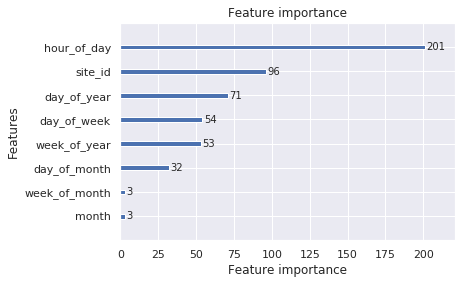

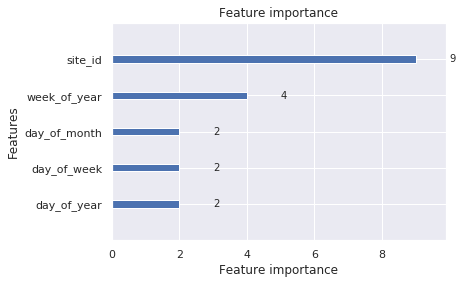

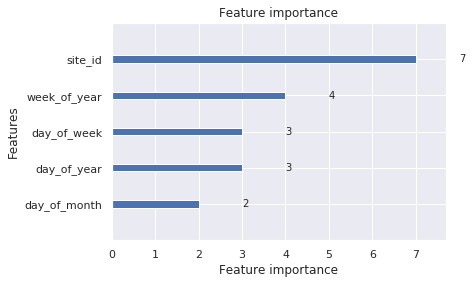

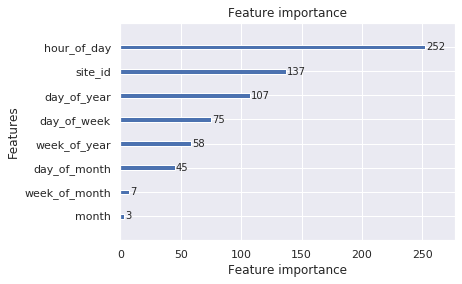

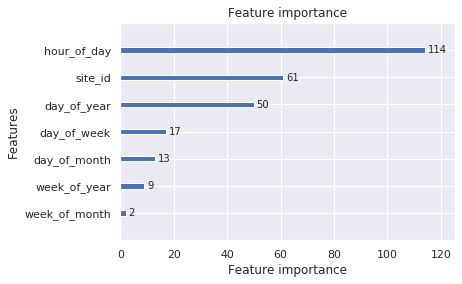

In [31]:
# feature Importance# 
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [ ]:
#prediction

results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(testdf, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(testdf, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

In [34]:
print(results)

[0.26422442 0.26422442 0.26422442 ... 0.35168081 0.35168081 0.30593323]


### Random Forest

In [279]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor()
rfr.fit(features,target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [280]:
# feature importance
print(clf.feature_importances_)

[0.46310681 0.00323981 0.01985669 0.09802455 0.25227066 0.07247894
 0.07727674 0.01374582]
